# Artificial Neural Networks as Propagators in Quantum Dynamics

In [18]:
#pip install tabulate  # Para imprimir la tabla en bonito formato

In [2]:
import random
import numpy as np
from numpy import ogrid
from numpy.linalg import eig
import matplotlib.pyplot as plt
import cmath
# Enable interactive plot
%matplotlib notebook
from tabulate import tabulate
import matplotlib.animation as anim
from scipy import integrate

color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

In [3]:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

Construyendo el grid n=100

In [4]:
n = 200j
r_n = ogrid[-1.5:1.5:n]  # Posicion en angstroms (0.1 nm)

In [5]:
r_n = r_n*(1/0.5291775)  # -> au

In [6]:
r_n[-1]

2.8345876383633093

Declarando variables iniciales tomadas del [Supporting Information, S2](https://pubs.acs.org/doi/10.1021/acs.jpclett.1c03117?goto=supporting-info&ref=pdf)  
**Nota:** En algunas variables se multiplica por un factor de conversión para trabajar con unidades atómicas.

In [79]:
## Random init values
V = 10*1.5936e-3  # Electronic coupling [kcal/mol] -> au
w1 = random.uniform(1500,4000)*4.556e-6   # Frecuencies of the harmonic proton potentials [cm^-1] -> au
w2 = random.uniform(1500,4000)*4.556e-6   # Frecuencies of the harmonic proton potentials [cm^-1] -> au
l = random.uniform(0,10)*1.5936e-3  # Amplitude of the energy bias [kcal/mol] -> au
x_eq = random.uniform(-10,10)*1.5936e-3  # Equilibrium energy bias [kcal/mol] -> au
w_x = 0.0148*(1/41.34144)  # Frequency of the energy bias oscillations [fs^-1] -> au
th_x = random.uniform(0, 2*np.pi)  # Initial phase. Zero for the time-independent potentials
R_eq = random.uniform(0.2, 1.0)*(1/0.5291775)  # Equilibrium distance between the minima of the harmonic potential [0.1nm] -> au 
R_0 = random.uniform(0, R_eq)  # Initial displacement from equilibrium
w_R = random.uniform(100, 300)*4.556e-6  # Frecuency of the proton-donor-acceptor distance oscillation [cm^-1] -> au
th_R = random.uniform(0, 2*np.pi)  # Random initial phase 
m = 1836  #The proton mass [au] 

In [117]:
print(tabulate([["V", V],["w1", w1], ["w2", w2], ["l", l], ["x_eq", x_eq], ["w_x", w_x], ["th_x", th_x], ["R_eq", R_eq], ["R_0", R_0], ["w_R", w_R], ["th_R", th_R], ["m", m]], headers=['Variable', 'Valor [au]'], tablefmt='orgtbl'))


| Variable   |     Valor [au] |
|------------+----------------|
| V          |    0.015936    |
| w1         |    0.0110287   |
| w2         |    0.0141751   |
| l          |    0.00755816  |
| x_eq       |    0.00891848  |
| w_x        |    0.000357994 |
| th_x       |    5.7759      |
| R_eq       |    1.51438     |
| R_0        |    1.17396     |
| w_R        |    0.00103848  |
| th_R       |    0.429406    |
| m          | 1836           |


### Funciones del sistema  
**Nota:** Se utilizan [unidades atómicas](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118229101.app5) para todas las variables de entrada en las funciones.

In [9]:
def X(t):
    """
    Variables:
    l : Amplitude of the energy bias [a_0]
    w_x: Frequency of the energy bias oscillations [Jiffy^-1]
    th_x: Initial phase
    x_eq: Equilibrium energy bias [au]
    
    Input:
    t: Time [Jiffy]
    
    Output:
    X_t: Collective energy gap coordinate [au]
    """
    X_t = l*np.cos(w_x*t+th_x) + x_eq
    return X_t
    
    
def R(t):
    """
    Variables:
    R_0: Initial displacement from equilibrium [a_0]
    R_eq: Equilibrium distance between the minima of the harmonic potential [a_0]
    w_R: Frecuency of the proton-donor-acceptor distance oscillation [cm^-1]
    th_R: Random initial phase
    
    Input:
    t : Time [Jiffy]
    
    Output:
    R_t: Vibrations of the proton donor and acceptor [a_0]
    """
    R_t = (R_0-R_eq)*np.cos(w_R*t+th_R) + R_eq
    return R_t
    
def u1(r, t):
    """
    Variables:
    m : Proton mass [m_e]
    w1: Frecuencies of the harmonic proton potentials [cm^-1]
    R(t): Vibrations of the proton donor and acceptor [a_0]
    
    Input:
    r: Proton coordinate [a_0]
    t: Time [Jify]
    
    Output:
    u1_t: Harmonic oscillator potential [au]
    
    """
    u1_t = (1/2)*m*(w1**2)*(r + (R(t)/2))**2
    return u1_t


def u2(r, t):
    """
    Variables:
    m : Proton mass [m_e]
    w2: Frecuencies of the harmonic proton potentials [cm^-1]
    R(t): Vibrations of the proton donor and acceptor [a_0]
    
    Input:
    r: Proton coordinate [a_0]
    t: Time [Jiffy]
    
    Output:
    u2_t: Harmonic oscillator potential [au]
    
    """
    u2_t = (1/2)*m*(w2**2)*(r - (R(t)/2))**2
    return u2_t

Construyendo la matriz de potencial. Tomado de la ec. (5) del [artículo principal](https://doi.org/10.1021/acs.jpclett.1c03117)

In [10]:
def matrix_potential(r, t):
    """
    Input:
    r: Proton coordinate [a_0]
    t: Time [Jiffy]
    
    Output:
    Potential Matrix
    
    """
    matrix = np.array([[u1(r,t),V],[V,u2(r,t) + X(t)]])
    return matrix

Calculando el eigenvalor más bajo de la matriz 2X2 de potencial

In [11]:
def potential(r,t):
    """
    Input:
    r: Proton coordinate [a_0]
    t: Time [Jiffy]
    
    Output:
    The lowest eigenvalue of potential matrix: Ground state  
    """
    e_val = np.linalg.eigvals(matrix_potential(r,t))
    
    if e_val[0] < e_val[1]:
        pot = e_val[0]
    else:
        pot = e_val[1]
    return pot

In [12]:
def potential2(r,t):
    """
    Input:
    r: Proton coordinate [a_0]
    t: Time [Jiffy]
    
    Output:
    The other eigenvalue of potential matrix: First excited estate  
    """
    e_val = np.linalg.eigvals(matrix_potential(r,t))
    
    if e_val[0] > e_val[1]:
        pot = e_val[0]
    else:
        pot = e_val[1]
    return pot

### Gráficas de potencial a diferentes tiempos $[fs]$

In [13]:
def vector_potential(t):
    """
    Input:
    t: Time [Jiffy]
    
    Output:
    Potential in the grid at time t (lenght: 32)
    """
    v_pot = np.zeros(len(r_n))
    for i, item in enumerate(r_n):
        v_pot[i] = potential(item, t)
 
    return v_pot

In [14]:
def vector_potential2(t):
    """
    Input:
    t: Time [Jiffy]
    
    Output:
    Potential in the grid at time t (lenght: 32)
    """
    
    v_2 = np.zeros(len(r_n))
    for i, item in enumerate(r_n):
        
        v_2[i] = potential2(item,t)
        
        
    return v_2

# Fig 3.2 Ground states

<IPython.core.display.Javascript object>


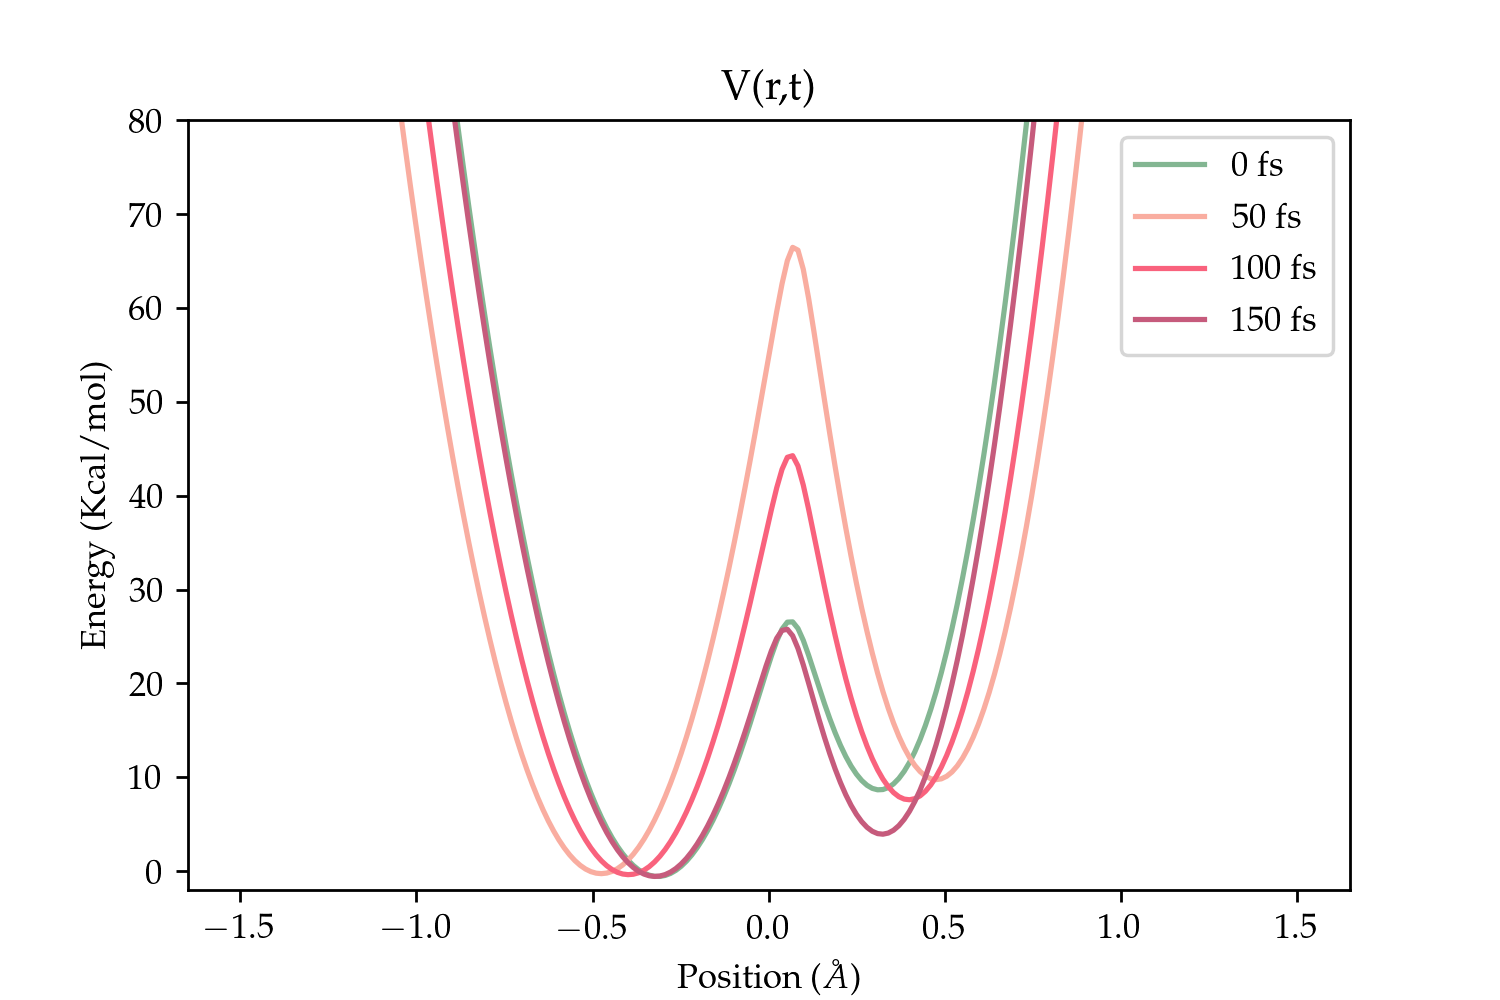

In [85]:
fig, ax = plt.subplots()
ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-2,80])

# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax.plot(r_n*0.5291775, vector_potential(0)*(1/1.5936e-3), "-", label="0 fs", color=color[0])
ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="50 fs", color=color[1])
ax.plot(r_n*0.5291775, vector_potential(100*41.34)*(1/1.5936e-3), "-", label="100 fs", color=color[2])
ax.plot(r_n*0.5291775, vector_potential(150*41.34)*(1/1.5936e-3), "-", label="150 fs", color=color[3])
#ax.plot(r_n*0.5291775, vector_potential(40*41.34)*(1/1.5936e-3), "-", label="40 fs", color=color[4])
#ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="50 fs")
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/ExamplesPotential1.png', dpi=300)


<IPython.core.display.Javascript object>


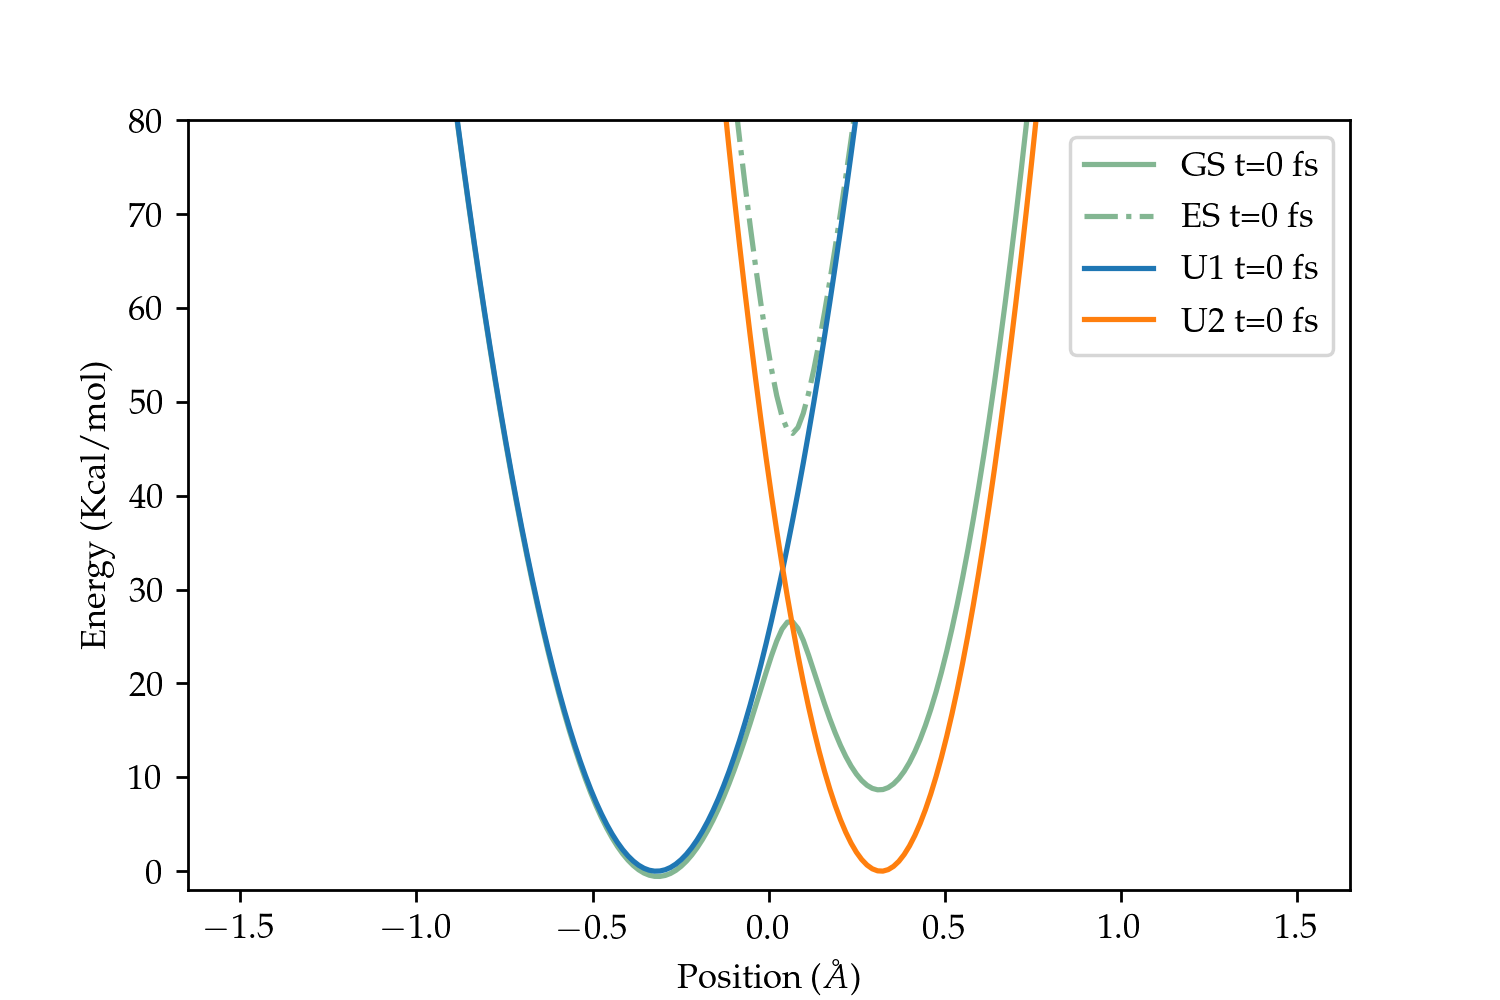

In [86]:
fig, ax = plt.subplots()
#ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-2, 80])

# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax.plot(r_n*0.5291775, vector_potential(0)*(1/1.5936e-3), "-", label="GS t=0 fs", color=color[0])
ax.plot(r_n*0.5291775, vector_potential2(0)*(1/1.5936e-3), "-.", label="ES t=0 fs", color=color[0])
'''
ax.plot(r_n*0.5291775, vector_potential(10*41.34)*(1/1.5936e-3), "-", label="GS 10 fs", color=color[1])
ax.plot(r_n*0.5291775, vector_potential2(10*41.34)*(1/1.5936e-3), "-.", label="ES 10 fs", color=color[1])

ax.plot(r_n*0.5291775, vector_potential(20*41.34)*(1/1.5936e-3), "-", label="GS 20 fs", color=color[2])
ax.plot(r_n*0.5291775, vector_potential2(20*41.34)*(1/1.5936e-3), "-.", label="ES 20 fs", color=color[2])

ax.plot(r_n*0.5291775, vector_potential(30*41.34)*(1/1.5936e-3), "-", label="GS 30 fs", color=color[3])
ax.plot(r_n*0.5291775, vector_potential2(30*41.34)*(1/1.5936e-3), "-.", label="ES 40 fs", color=color[3])

ax.plot(r_n*0.5291775, vector_potential(40*41.34)*(1/1.5936e-3), "-", label="GS 40 fs", color=color[4])
ax.plot(r_n*0.5291775, vector_potential2(40*41.34)*(1/1.5936e-3), "-.", label="ES 40 fs", color=color[4])

ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="GS 50 fs")
ax.plot(r_n*0.5291775, vector_potential2(50*41.34)*(1/1.5936e-3), "-.", label="ES 20 fs", color='C0')
'''
ax.plot(r_n*0.5291775, u1(r_n,0)*(1/1.5936e-3), "-", label="U1 t=0 fs",color='C0')
ax.plot(r_n*0.5291775, u2(r_n,0)*(1/1.5936e-3), "-", label="U2 t=0 fs",color='C1')

plt.gcf().set_size_inches(6, 4)


ax.legend()
plt.savefig('/home/jessica/Tesis/img/tesis/ExamplesGSandES.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


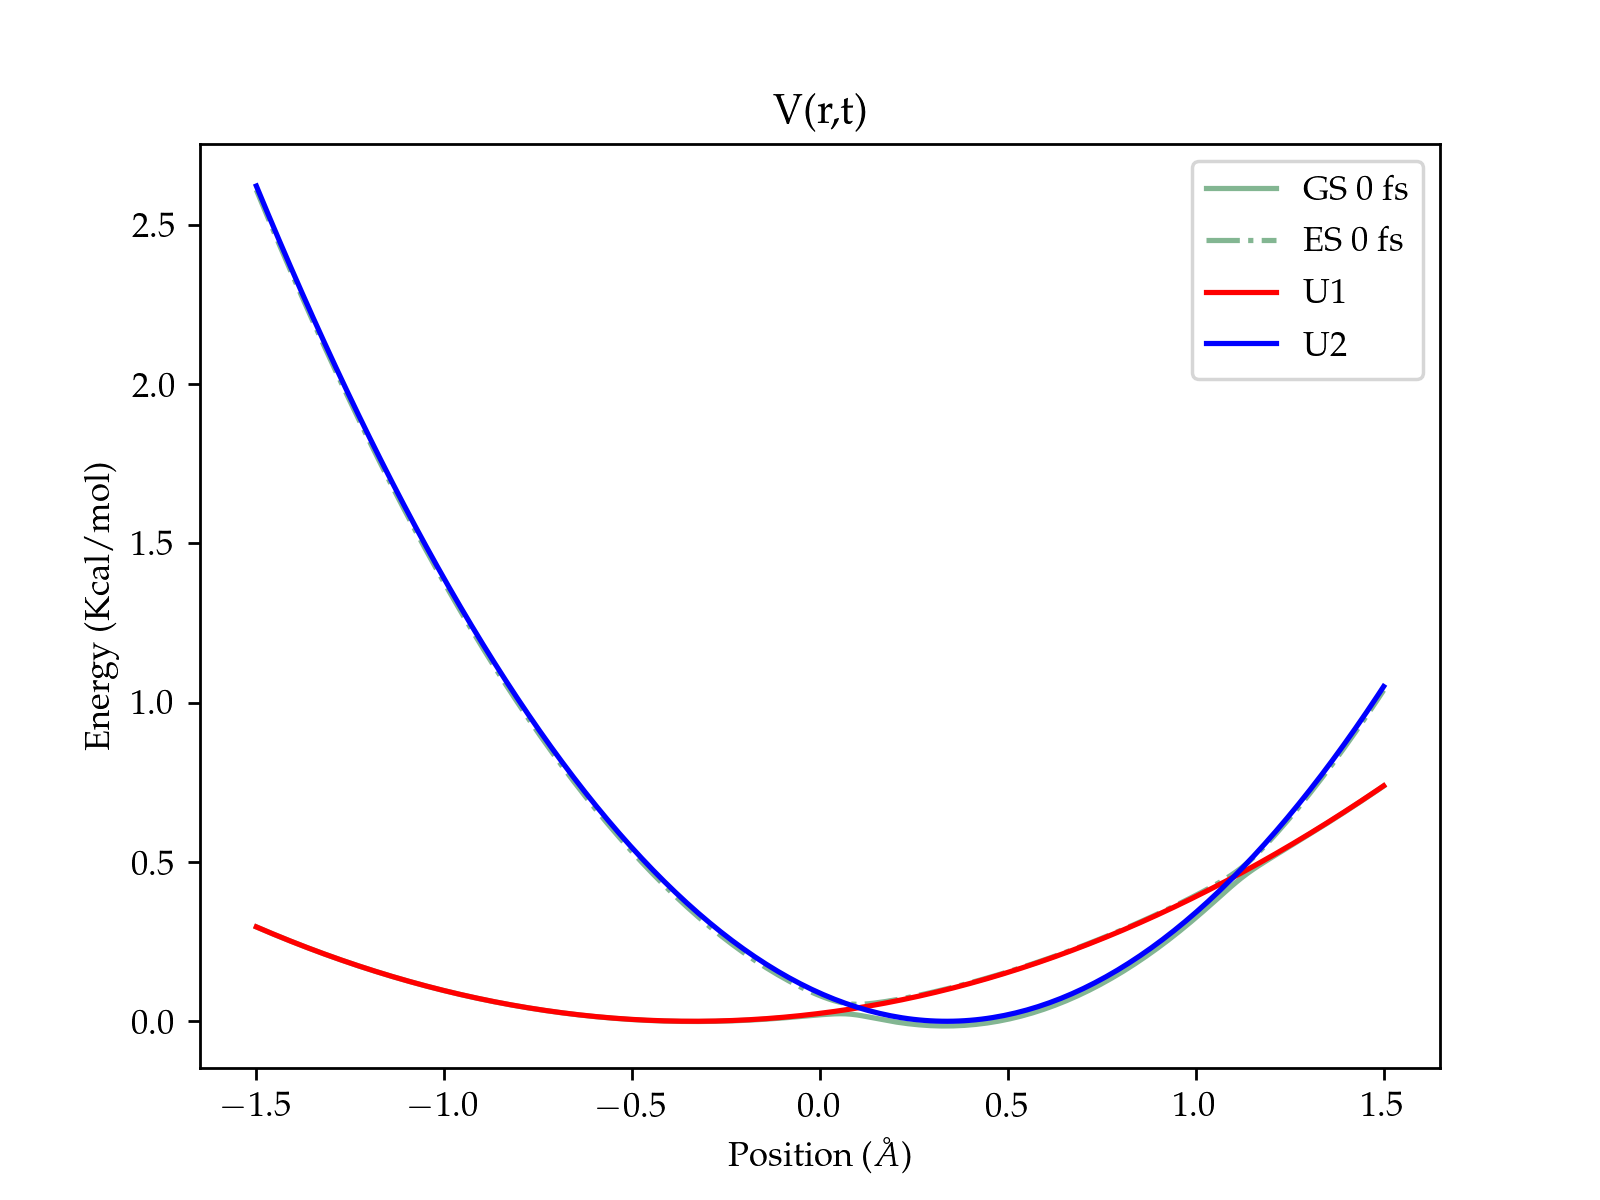

In [61]:
fig, ax = plt.subplots()
ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
#ax.set_ylim([-20, 100])

ax.plot(r_n*0.5291775, vector_potential(20), "-", label="GS 0 fs", color=color[0])
ax.plot(r_n*0.5291775, vector_potential2(20), "-.", label="ES 0 fs", color=color[0])

ax.plot(r_n*0.5291775, u1(r_n,20), "-", label="U1",color='red')
ax.plot(r_n*0.5291775, u2(r_n,20), "-", label="U2",color='blue')


ax.legend()
plt.show()

<IPython.core.display.Javascript object>


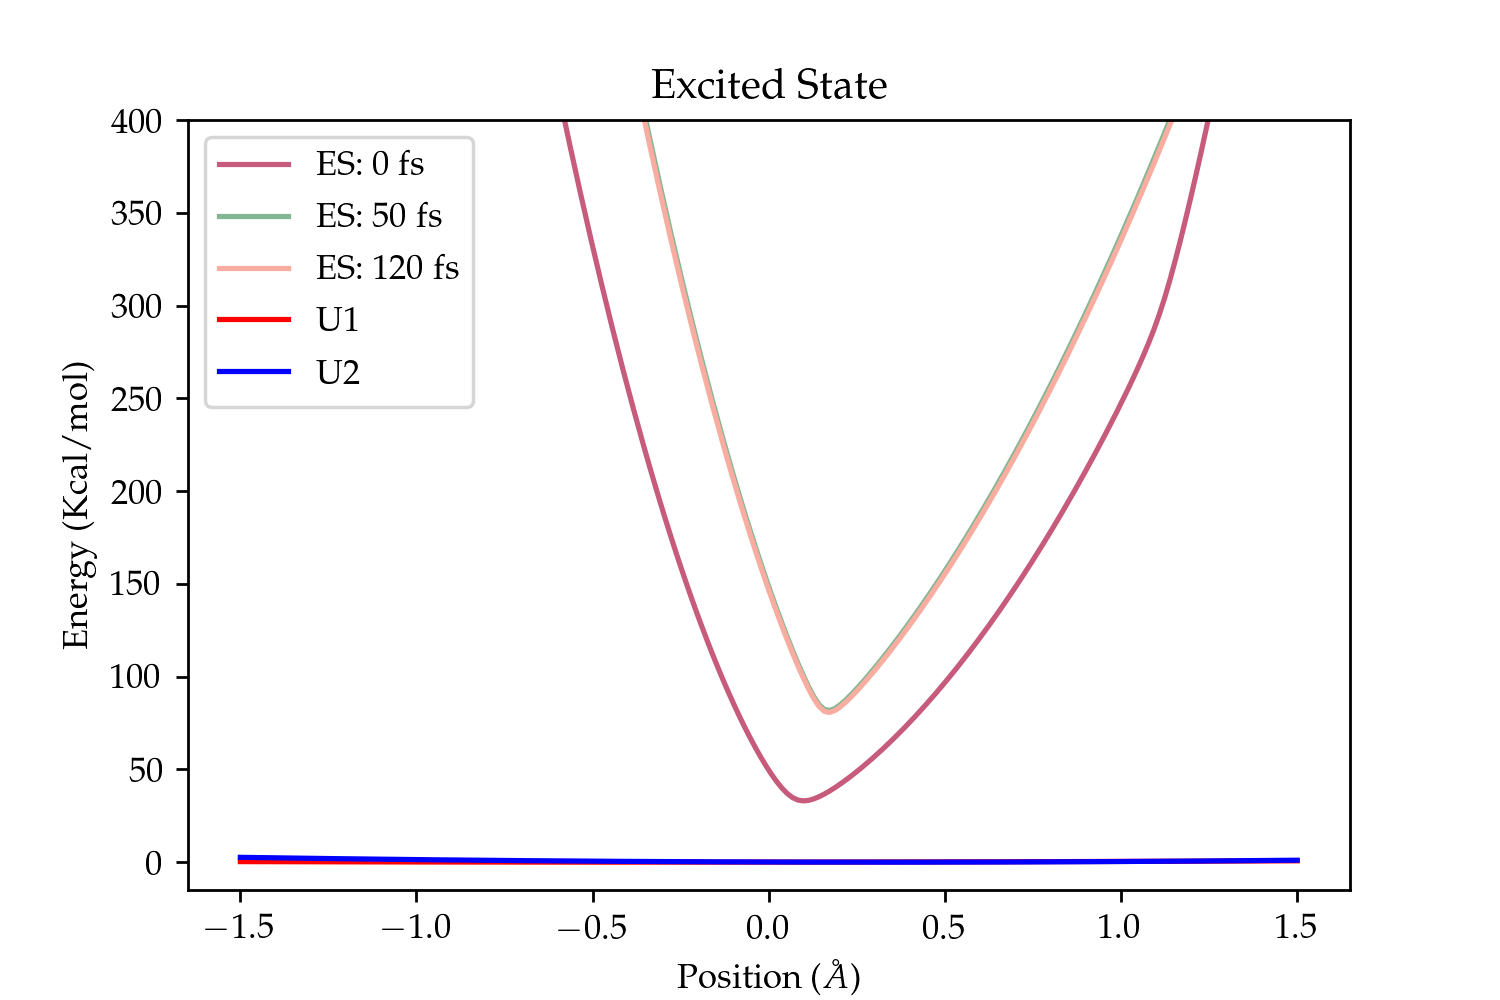

In [13]:
fig, ax = plt.subplots()
#ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-15, 400])
ax.set_title('Excited State')

# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
#ax.plot(r_n*0.5291775, vector_potential(0)*(1/1.5936e-3), "-", label="GS: 0 fs",color=color[3])
ax.plot(r_n*0.5291775, vector_potential2(0)*(1/1.5936e-3), "-", label="ES: 0 fs",color=color[3])
#ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="GS: 50 fs",color=color[0])
ax.plot(r_n*0.5291775, vector_potential2(50*41.34)*(1/1.5936e-3), "-", label="ES: 50 fs",color=color[0])
ax.plot(r_n*0.5291775, vector_potential2(120*41.34)*(1/1.5936e-3), "-", label="ES: 120 fs",color=color[1])

ax.plot(r_n*0.5291775, u1(r_n,0), "-", label="U1",color='red')
ax.plot(r_n*0.5291775, u2(r_n,0), "-", label="U2",color='blue')

ax.legend()
plt.gcf().set_size_inches(6, 4)
plt.show()

<IPython.core.display.Javascript object>


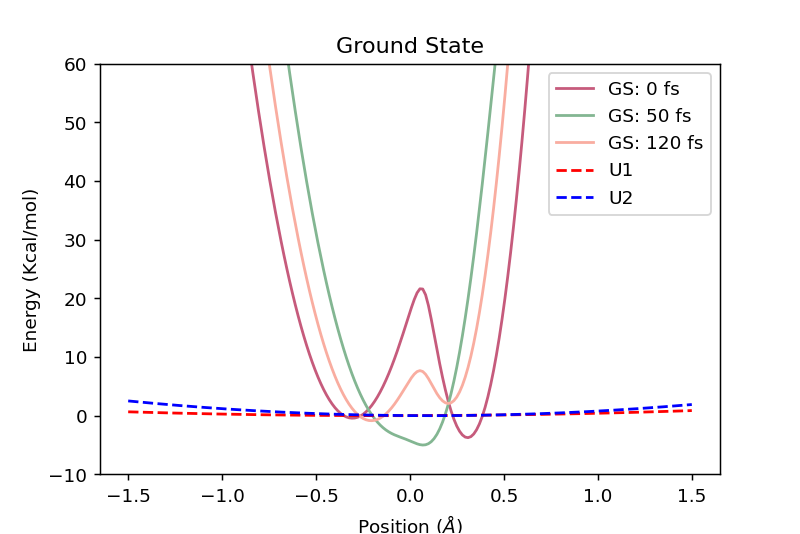

In [79]:
fig, ax = plt.subplots()
#ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-10, 60])
ax.set_title('Ground State')

# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax.plot(r_n*0.5291775, vector_potential(0)*(1/1.5936e-3), "-", label="GS: 0 fs",color=color[3])
ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="GS: 50 fs",color=color[0])
ax.plot(r_n*0.5291775, vector_potential(120*41.34)*(1/1.5936e-3), "-", label="GS: 120 fs",color=color[1])
#ax.plot(r_n*0.5291775, vector_potential(150*41.34)*(1/1.5936e-3), "-", label="150 fs",color=color[3])
#ax.plot(r_n*0.5291775, vector_potential(200*41.34)*(1/1.5936e-3), "-", label="200 fs",color=color[4])
#ax.plot(r_n*0.5291775, vector_potential(50*41.34)*(1/1.5936e-3), "-", label="50 fs")
ax.plot(r_n*0.5291775, u1(r_n,100*41.34), "--", label="U1",color='red')
ax.plot(r_n*0.5291775, u2(r_n,100*41.34), "--", label="U2",color='blue')
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/img/tesis/ExamplesPotential1Ap11.png', dpi=700)

### Eigenestados  $\phi_n(r)$

Eigenestados tomados de la referencia: [The Fourier grid Hamiltonian method for bound state eigenvalues and
eigenfunctions, A1](http://dx.doi.org/10.1063/1.462100)  
**Nota:** Se considera que las funciones de onda $\phi_i$ se hacen 0 en los extremos, i.e. en x=-1.5 y en x=1.5, para toda $i$

In [87]:
a = r_n[0]  #[-1.5 angstroms = -2.83 au]
b = r_n[-1]  #[-1.5 angstroms = 2.83 au]

def eigenestados(r, m):
    e_m =((2/(b-a))**(1/2))*np.sin((m*np.pi*(r-a))/(b-a))
    return e_m

In [88]:
def phi_i(m):
    phi = np.zeros(len(r_n))
    for j, item in enumerate(r_n):
        phi[j] = eigenestados(item, m)
    return phi

In [89]:
harm1 = phi_i(1)
harm2 = phi_i(2)
harm3 = phi_i(3)
harm4 = phi_i(4)
harm5 = phi_i(5)

<IPython.core.display.Javascript object>


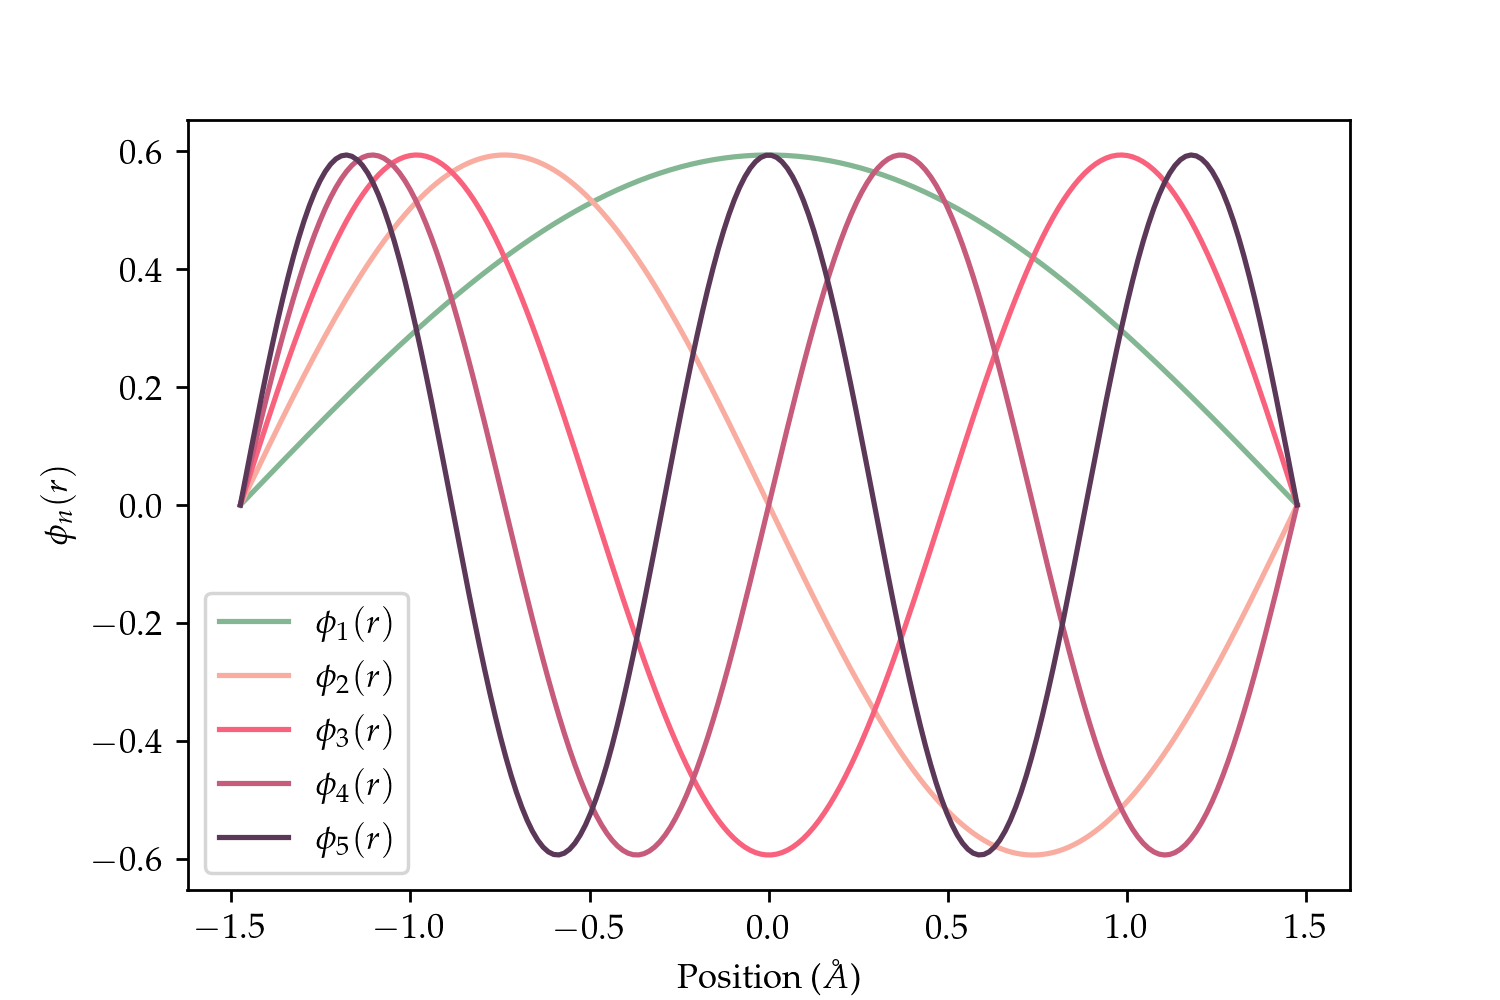

In [93]:
fig, ax = plt.subplots()
#ax.set_title(r"Eigenestados")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\phi_n(r)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.52, harm1, label="$\phi_1(r)$",color=color[0])
ax.plot(r_n*0.52, harm2, label="$\phi_2(r)$",color=color[1])
ax.plot(r_n*0.52, harm3, label="$\phi_3(r)$",color=color[2])
ax.plot(r_n*0.52, harm4, label="$\phi_4(r)$",color=color[3])
ax.plot(r_n*0.52, harm5, label="$\phi_5(r)$",color=color[4])
#plt.gcf().set_size_inches(6, 4)
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/Phi_n1.png', dpi=300)

### Construyendo el wavapacket $\Psi(r)$  
$\Psi(r) = \sum_{i=1}^{k=5}C_i\Phi_i(r)$

Tomado de la ec. (10) del [artículo principal](https://doi.org/10.1021/acs.jpclett.1c03117)

In [90]:
def random_Ci():
    cix = random.random()
    ciy = random.random()
    Ci = complex(cix,ciy)
    return Ci
    

In [91]:
def wavepacket(k=5):
    random.seed(0)
    Ci_norm = []
    wavei = np.zeros([k,len(r_n)], dtype = 'complex_')
    for i in range(1,k+1):
        Ci = random_Ci()
        Ci_norm.append(np.abs(Ci)**2)
        wavei[i-1,:] = Ci*(phi_i(i))
    wave = sum(wavei[i] for i in range(k))   # Aproximation        
        
    return wave/np.sqrt(sum(Ci_norm))
        

### Wavepacket 1

In [92]:
ci1 = wavepacket()

<IPython.core.display.Javascript object>


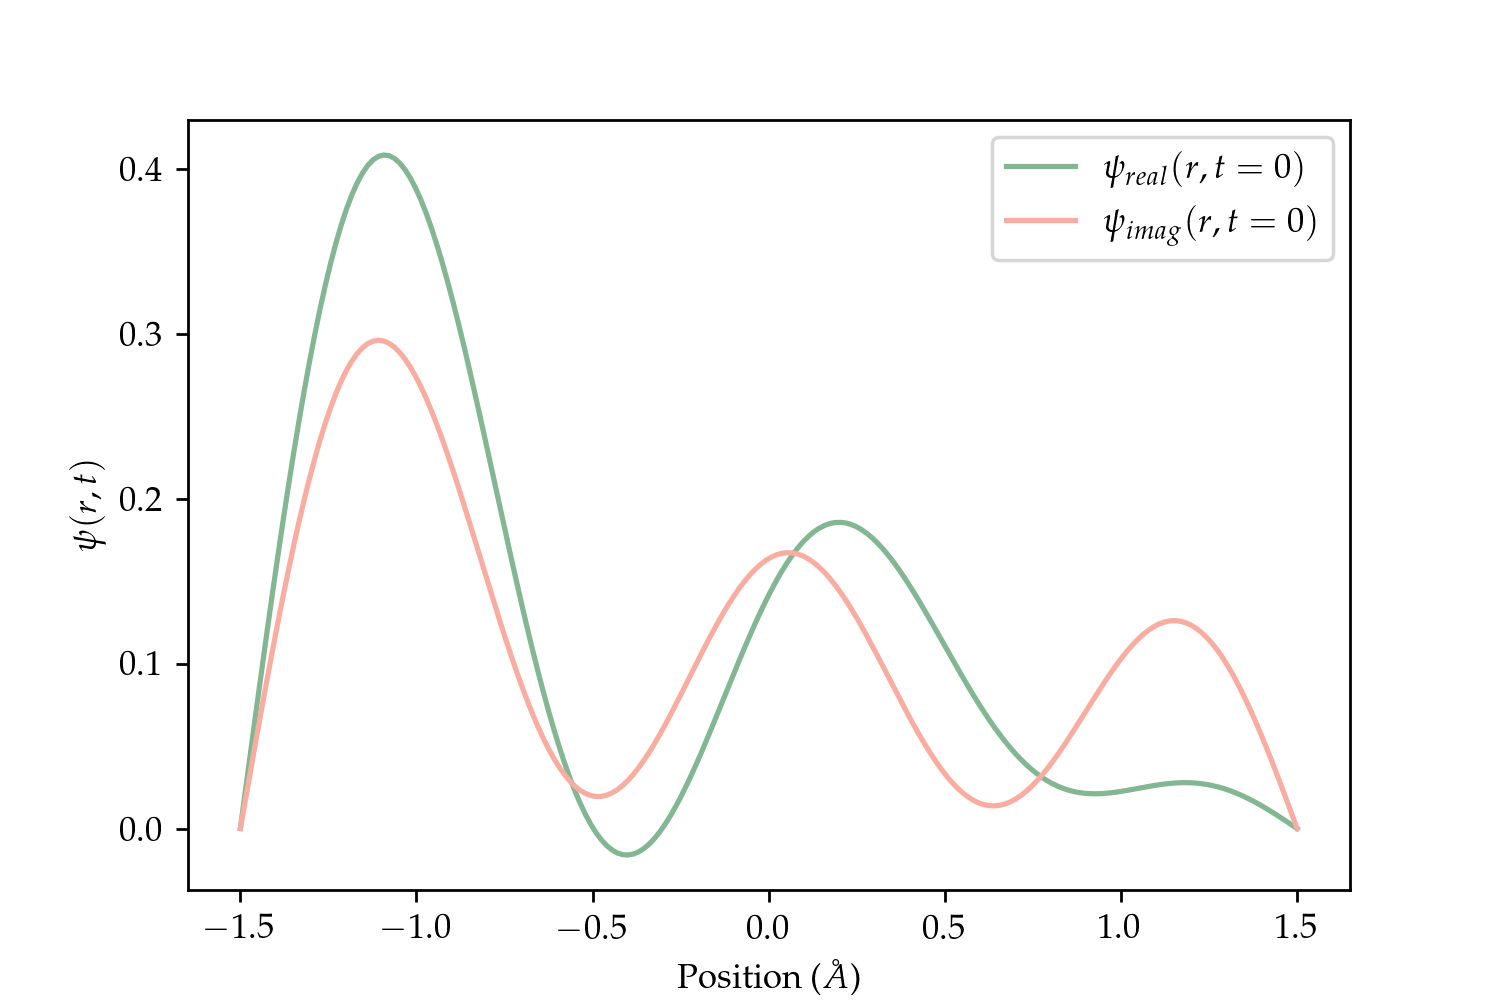

In [97]:
fig, ax = plt.subplots()
#ax.set_title(r"$\Psi(r,t=0)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, ci1.real*0.529, label="$\psi_{real}(r, t=0)$", color=color[0])
ax.plot(r_n*0.5291775, ci1.imag*0.529, label="$\psi_{imag}(r, t=0)$", color=color[1])
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/img/tesis/psi_01', dpi=700)

<IPython.core.display.Javascript object>


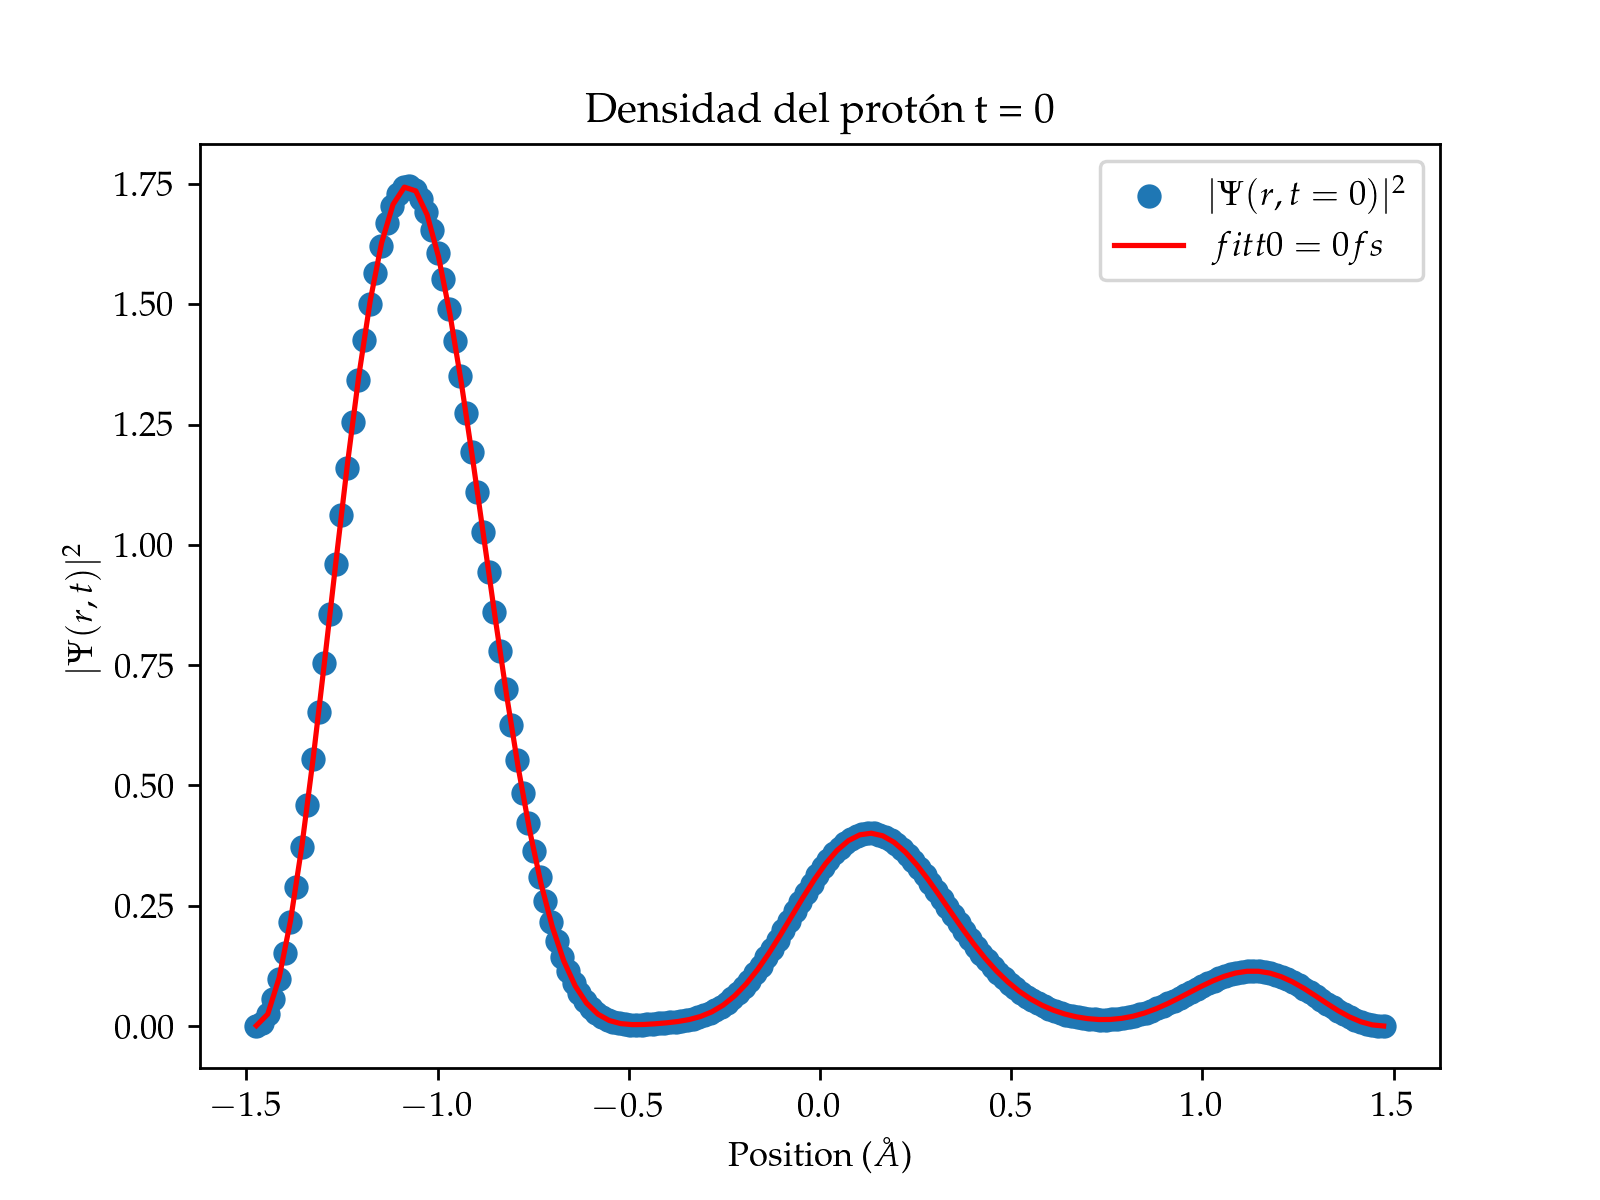

In [98]:
fig, ax = plt.subplots()
ax.set_title(r"Densidad del protón t = 0")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$|\Psi(r,t)|^{2}$')

# Lenght: au -> Angstroms
ax.scatter(r_n*0.52, ((np.abs(ci1))**2)*(1/0.52), label="$|\Psi(r, t=0)|^{2}$")
ax.legend()
plt.show()

In [99]:
dens0 = ((np.abs(ci1))**2)
model20_0t = np.poly1d(np.polyfit(r_n*0.52, dens0*(1/0.52), 20))

polyline = np.linspace(r_n[0]*0.52, r_n[-1]*0.52, 100)
plt.plot(polyline, model20_0t(polyline), label='$fit t0 = 0 fs$', color='red')
plt.legend()
plt.show()

In [100]:
integral = model20_0t.integ(m=1, k=0)
integraldef = integral(r_n[-1]*0.52)-integral(r_n[0]*0.52)
integraldef

0.999990741992663

**Nota sobre las unidades:** Para mostrar las gráficas se utilizan unidades de $Å, kcal/mol$ por lo que se utilizan los factores de conversión correspondientes al gráficar.

### Gaussian wavepacket

In [93]:
def gaussi(x):
    mu = np.random.uniform(-0.5,0.5)*(1/0.5291775)
    sigma = np.random.uniform(0.1,0.3)*(1/0.5291775)
    Ci = random_Ci()
    g = Ci*(1/sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2)/(2*sigma**2))
    
    norm = integrate.simpson((np.abs(g)**2), x)
    return g/np.sqrt(norm)

In [94]:
onda_gauss = gaussi(r_n)

<IPython.core.display.Javascript object>


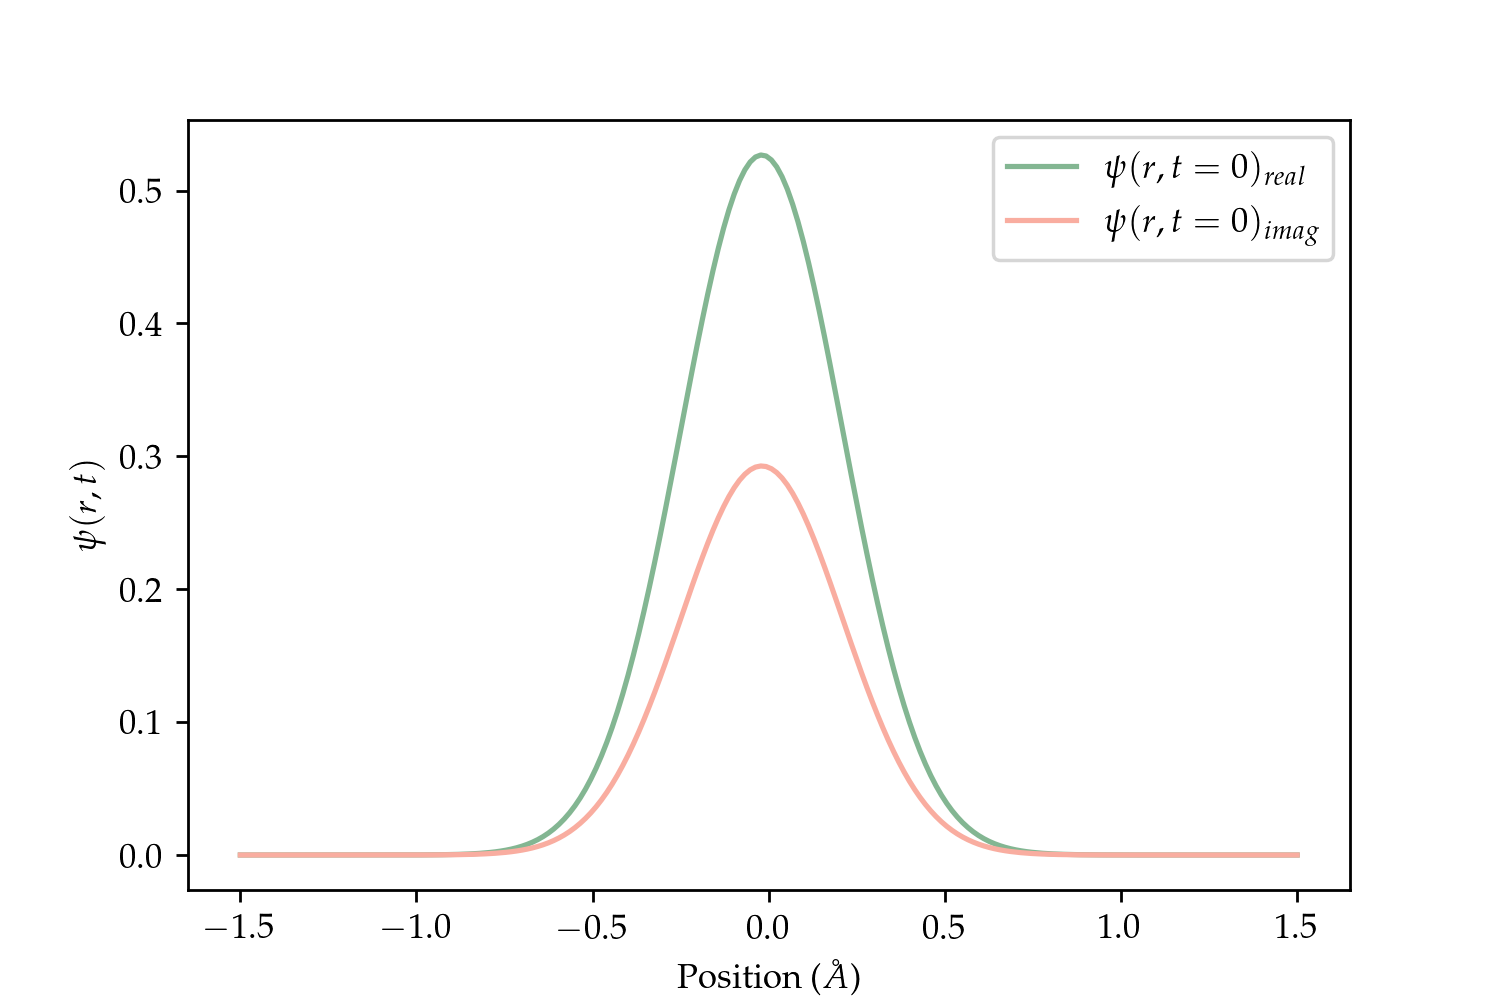

In [112]:
fig, ax = plt.subplots()
#ax.set_title(r"$\Psi(r,t=0)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, onda_gauss.real*0.529, label="$\psi(r, t=0)_{real}$", color=color[0])
ax.plot(r_n*0.5291775, onda_gauss.imag*0.529, label="$\psi(r, t=0)_{imag}$", color=color[1])
plt.gcf().set_size_inches(6, 4)
ax.legend()
plt.savefig('/home/jessica/Tesis/img/tesis/psi_01', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


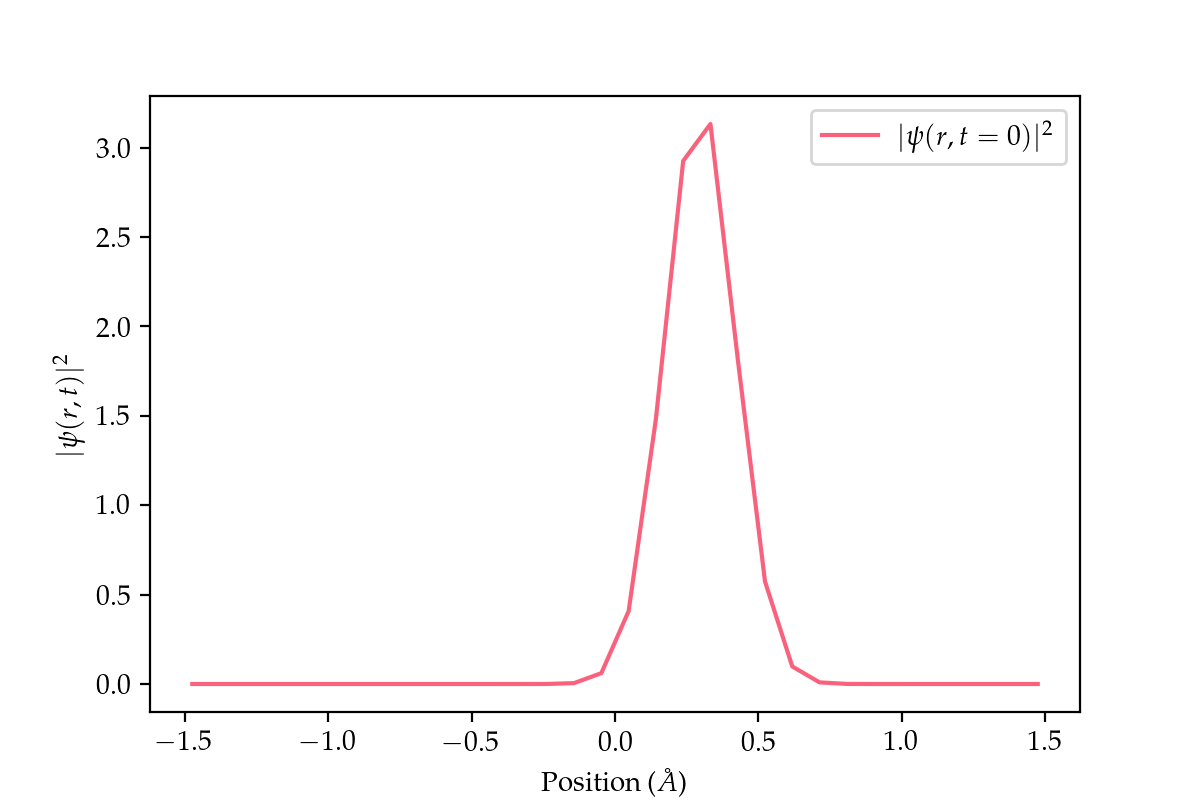

In [45]:
fig, ax = plt.subplots()
#ax.set_title(r"Density Gaussian wavepacket initial t = 0")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$|\psi(r,t)|^2$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.52, (1/0.52)*np.abs(onda_gauss)**2, label="$|\psi(r, t=0)|^{2}$", color=color[2])
ax.legend()
plt.gcf().set_size_inches(6, 4)

plt.show()

### Evolucion temporal de un wavepacket bajo el potencial dado   
### Método DVR


**Referencias: David J.Tannor Introduction to Quantum Mechanics**  
- Chapter 11: Eq.(11.12) pág 289
- Chapter 11.5.2 The DVR Algorithm pág 313*

Calculando la [matriz de energía cinética](https://aip.scitation.org/doi/10.1063/1.462100) $T_{DVR}$

In [114]:
t = np.empty((2,2))

In [116]:
m

1836

In [96]:
def T_spec():
    """
    Kinetic Energy Matrix in the spectral basis
    """
    h_bar = 1  # Planck constant [au]
    N = len(r_n)
    L = r_n[-1] - r_n[0]
    
    T = np.empty((N,N))
    
    for i in range(1,N+1):
        for j in range(1,N+1):
            
            if i != j:
                T[i-1,j-1] = 0
            else:
                T[i-1,j-1] = (h_bar**2/(2*m))*((j*np.pi)/L)**2 
                
    return T
    
    
def Unitary_Matrix():
    """
    Unitary Matrix of transformation from spectral to pseudospectral basis 
    """
    N = len(r_n)
    
    U = np.empty((N, N))
    
    for i in range(1,N+1):
        for j in range(1,N+1):
    
            U[i-1,j-1] = np.sqrt(2/(N+1))*np.sin((i*j*np.pi)/(N+1))
    
    return U
    

def KINETIC_DVR():
    """
    Kinetic Energy Matrix in the pseudospectral basis
    """
    N = len(r_n)
        
    U = Unitary_Matrix()
    T_spectral = T_spec()
        
    T_DVR = np.matmul(np.matmul(U,T_spectral),U)
        
    return T_DVR

def senno(k,l,n):
    y = (n**2)*(np.sin((n*np.pi*k)/(len(r_n))))*(np.sin((n*np.pi*l)/(len(r_n))))
    return y


def KINETIC_DVR():
    h_bar = 1  # Constante de Planck en au
    T_c = ((h_bar**2)/(2*m))*((np.pi/(b-a))**2)*(2/32)
    T1 = np.arange(1,len(r_n)-1)
    
    T_DVR = np.zeros((len(r_n),len(r_n)))  # Matriz de enerfía cinética (fija) [au]

    for i in range(1,len(r_n)-1):
        for j in range(1,len(r_n)-1):
            c = []
            for n in T1:
                c.append(senno(i,j,n))
        #T_DVR[i,j] = T_c*sum(c)*(1/1.5936e-3)  # au -> kcal/mol)
            T_DVR[i,j] = T_c*sum(c)
        
    return T_DVR
    

In [97]:
T_DVR = KINETIC_DVR()

In [98]:
T_DVR*(1/1.5936e-3)  # au -> kcal/mol

array([[ 5.99313455e+02, -3.81898387e+02,  8.05566900e+01, ...,
        -1.92455570e-05,  1.28251501e-05, -6.41100929e-06],
       [-3.81898387e+02,  6.79870145e+02, -4.12450257e+02, ...,
         3.85005299e-05, -2.56565689e-05,  1.28251513e-05],
       [ 8.05566900e+01, -4.12450257e+02,  6.94788049e+02, ...,
        -5.77743440e-05,  3.85005333e-05, -1.92455626e-05],
       ...,
       [-1.92455570e-05,  3.85005299e-05, -5.77743440e-05, ...,
         6.94788049e+02, -4.12450257e+02,  8.05566900e+01],
       [ 1.28251501e-05, -2.56565689e-05,  3.85005333e-05, ...,
        -4.12450257e+02,  6.79870145e+02, -3.81898387e+02],
       [-6.41100929e-06,  1.28251513e-05, -1.92455626e-05, ...,
         8.05566900e+01, -3.81898387e+02,  5.99313455e+02]])

En kcal/mol tiene órdenes de magnitud semejantes al potencial 

El potencial es una matriz diagonal, que se calcula con el modelo desarrollado en las primeras líneas de código. 
$V_{DVR}$

In [99]:
def V_DVR(t):
    """
    Input: t [au]
    
    Output: Matriz de potencial en el grid: V_DVR [au]
    """
    V = np.zeros((len(r_n),len(r_n)))
    
    for i, r in enumerate(r_n):
        V[i,i] = potential(r,(t))#*(1/1.5936e-3)  # time: fs -> au, energy: Hartree -> kcal/mol
        
    return V

El Hamiltoniano correspondiente entonces es: $H_{DVR}=T_{DVR}+V_{DVR}$

In [100]:
def H_DVR(t):
    """
    input: tiempo [fs]
    
    output: Matriz Hamiltoniana DVR [au]
    """
    T_DVR = KINETIC_DVR()
    t = t*41.34  # fs -> au
    H = T_DVR + V_DVR(t)
    return H

### Evolución temporal del wavepacket 1

$$\Psi_N(t) = e^{-iH_Nt/\hbar}\Psi_N(0)$$  
Si $H_N = UDU^{-1}$, con $D$ una matriz diagonal:
$$\rightarrow \Psi_N(t) = e^{-iUDU^{-1}t/\hbar}\Psi_N(0)$$  

$$\rightarrow \Psi_N(t) = Ue^{\frac{-it}{\hbar}D}U^{-1}\Psi_N(0)$$  
*$\hbar = 1$ en au*

In [101]:
# Encontramos eigenvalores y eigenvectores:
def eigenN(t):
    Eigen_n, U = eig(H_DVR(t))
    
    U_inv = np.linalg.inv(U)
    
    D = np.dot(np.dot(U_inv, H_DVR(t)),U)
    D = (complex(0,-1))*t*D
        
    return Eigen_n, U, U_inv, D


In [102]:
def Psi_VDR_t(t, Psi_DVR_inicial):
    
    Eigen_n, U, U_inv, D = eigenN(t)
    
    Diag = np.zeros([len(r_n),len(r_n)], dtype = 'complex_')
    for i in range(len(r_n)):
        Diag[i][i] = np.exp(np.diagonal(D))[i]
    
    
    Psi_DVR_final = np.dot((np.dot(np.dot(U, Diag),U_inv)),Psi_DVR_inicial)
    
    # Normalizacion:
    norm = integrate.simpson((np.abs(Psi_DVR_final)**2), r_n)
        
    
    return Psi_DVR_final/np.sqrt(norm)

In [103]:
def evolucion_wp(t):
    #random.seed(0)
    """
    Función que calcula la evolución del wavepacket inicial a un tiempo t bajo el potencial dado.
    Los intervalos de tiempo son de 1 fs
    
    Input:
    t: tiempo de evolución [fs]
    
    Output:
    wp: Wavepacket evolucionado con el método DVR bajo el potencial V(t)
    """
    if t == 0:
        return wavepacket()  # NOTA fijar semilla para variables aleatorias
    else:
        wp = Psi_VDR_t(t, evolucion_wp(t-1))
        return wp
    

## Gaussiana evolution

In [104]:
def Gauss_evolucion_wp(t):
    #random.seed(0)
    """
    Función que calcula la evolución del wavepacket inicial a un tiempo t bajo el potencial dado.
    Los intervalos de tiempo son de 1 fs
    
    Input:
    t: tiempo de evolución [fs]
    
    Output:
    wp: Wavepacket evolucionado con el método DVR bajo el potencial V(t)
    """
    if t == 0:
        return onda_gauss  # Initial gaussian wavepacket (Example)
    else:
        wp = Psi_VDR_t(t, Gauss_evolucion_wp(t-1))
        return wp

In [105]:
onda_gauss1 = Gauss_evolucion_wp(0)

In [106]:
onda_gauss2 = Gauss_evolucion_wp(50)

In [107]:
onda_gauss3 = Gauss_evolucion_wp(100)

In [108]:
onda_gauss4 = Gauss_evolucion_wp(150)

In [150]:
wavet2 = Psi_VDR_t(1, ci1)
wavet3 = Psi_VDR_t(5, wavet2)
wavet4 = Psi_VDR_t(10, wavet3)
wavet5 = Psi_VDR_t(15, wavet4)
wavet6 = Psi_VDR_t(20, wavet5)

<IPython.core.display.Javascript object>


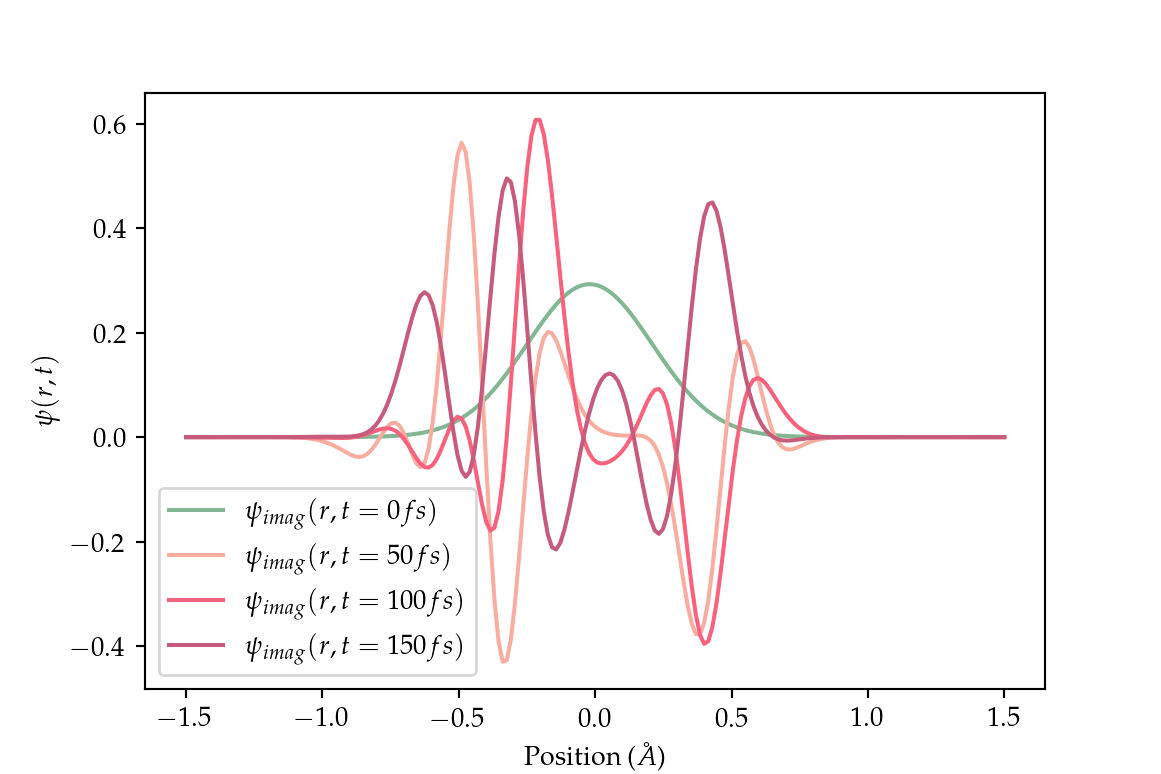

In [215]:
fig, ax = plt.subplots()
#ax.set_title(r"Evolución de wavepacket t parte real")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, onda_gauss1.imag*0.529, label="$\psi_{imag}(r, t=0 fs)$", color=color[0])
ax.plot(r_n*0.5291775, onda_gauss2.imag*0.529, label="$\psi_{imag}(r, t=50 fs)$", color=color[1])
ax.plot(r_n*0.5291775, onda_gauss3.imag*0.529, label="$\psi_{imag}(r, t=100 fs)$", color=color[2])
ax.plot(r_n*0.5291775, onda_gauss4.imag*0.529, label="$\psi_{imag}(r, t=150 fs)$", color=color[3])
#ax.plot(r_n*0.5291775, wavet5.imag*0.529, label="$\psi_{imag}(r, t=20 fs)$", color=color[4])
#ax.plot(r_n*0.5291775, wavet6.real*0.529, label="$\psi_{real}(r, t=5 fs)$")
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/psi_ev1real', dpi=300)

<IPython.core.display.Javascript object>


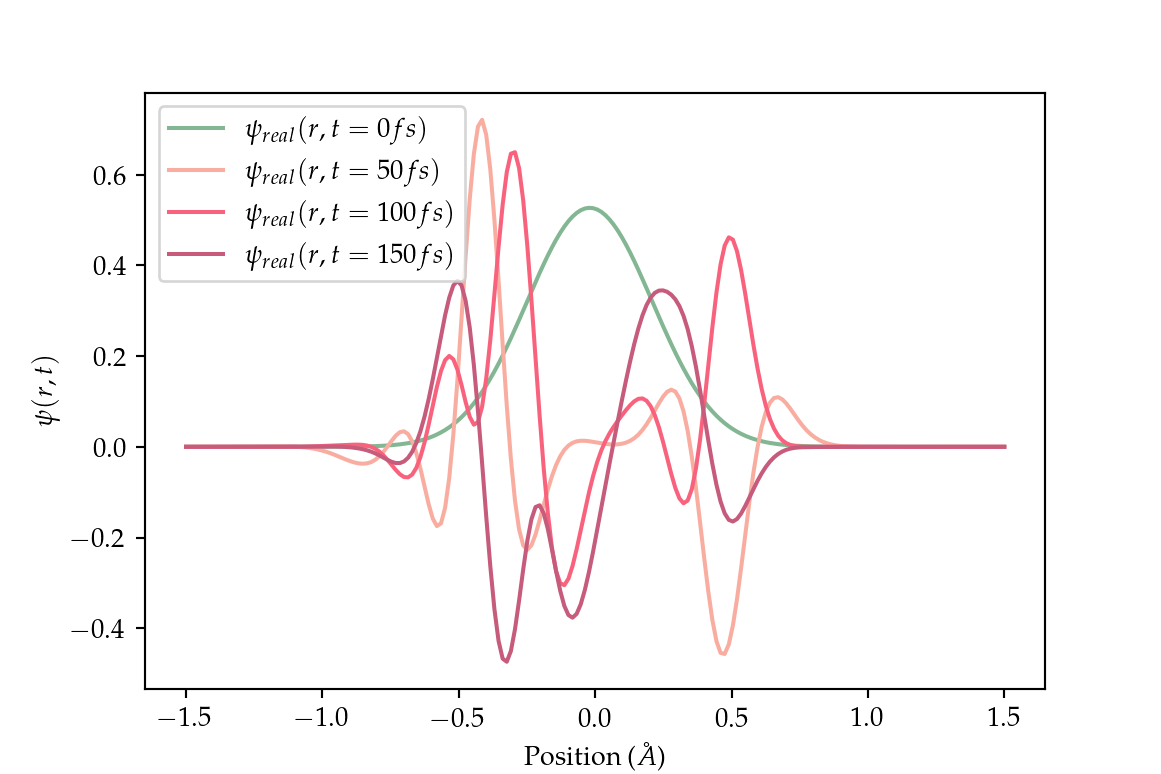

In [216]:
fig, ax = plt.subplots()
#ax.set_title(r"Evolución de wavepacket t parte real")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, onda_gauss1.real*0.529, label="$\psi_{real}(r, t=0 fs)$", color=color[0])
ax.plot(r_n*0.5291775, onda_gauss2.real*0.529, label="$\psi_{real}(r, t=50 fs)$", color=color[1])
ax.plot(r_n*0.5291775, onda_gauss3.real*0.529, label="$\psi_{real}(r, t=100 fs)$", color=color[2])
ax.plot(r_n*0.5291775, onda_gauss4.real*0.529, label="$\psi_{real}(r, t=150 fs)$", color=color[3])
#ax.plot(r_n*0.5291775, wavet5.imag*0.529, label="$\psi_{imag}(r, t=20 fs)$", color=color[4])
#ax.plot(r_n*0.5291775, wavet6.real*0.529, label="$\psi_{real}(r, t=5 fs)$")
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/psi_ev1imag', dpi=300)

<IPython.core.display.Javascript object>


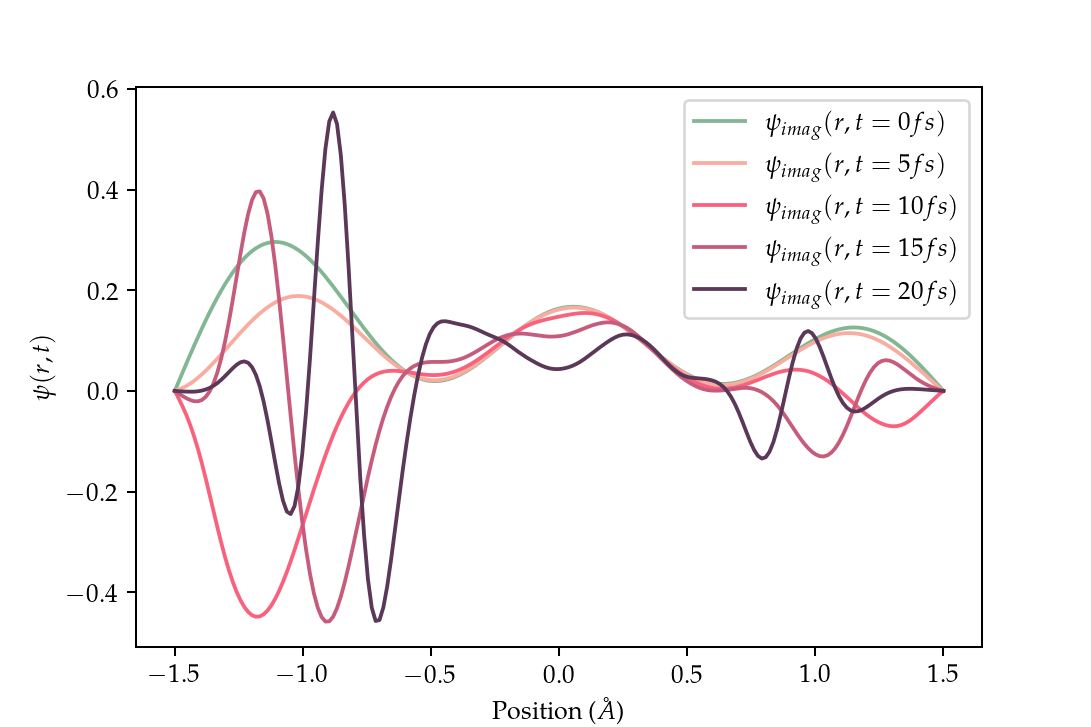

In [156]:
fig, ax = plt.subplots()
#ax.set_title(r"Evolución de wavepacket t parte real")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, ci1.imag*0.529, label="$\psi_{imag}(r, t=0 fs)$", color=color[0])
ax.plot(r_n*0.5291775, wavet2.imag*0.529, label="$\psi_{imag}(r, t=5 fs)$", color=color[1])
ax.plot(r_n*0.5291775, wavet3.imag*0.529, label="$\psi_{imag}(r, t=10 fs)$", color=color[2])
ax.plot(r_n*0.5291775, wavet4.imag*0.529, label="$\psi_{imag}(r, t=15 fs)$", color=color[3])
ax.plot(r_n*0.5291775, wavet5.imag*0.529, label="$\psi_{imag}(r, t=20 fs)$", color=color[4])
#ax.plot(r_n*0.5291775, wavet6.real*0.529, label="$\psi_{real}(r, t=5 fs)$")
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
#plt.savefig('/home/jessica/Tesis/img/tesis/psi_ev1imag.png', dpi=700)

<IPython.core.display.Javascript object>


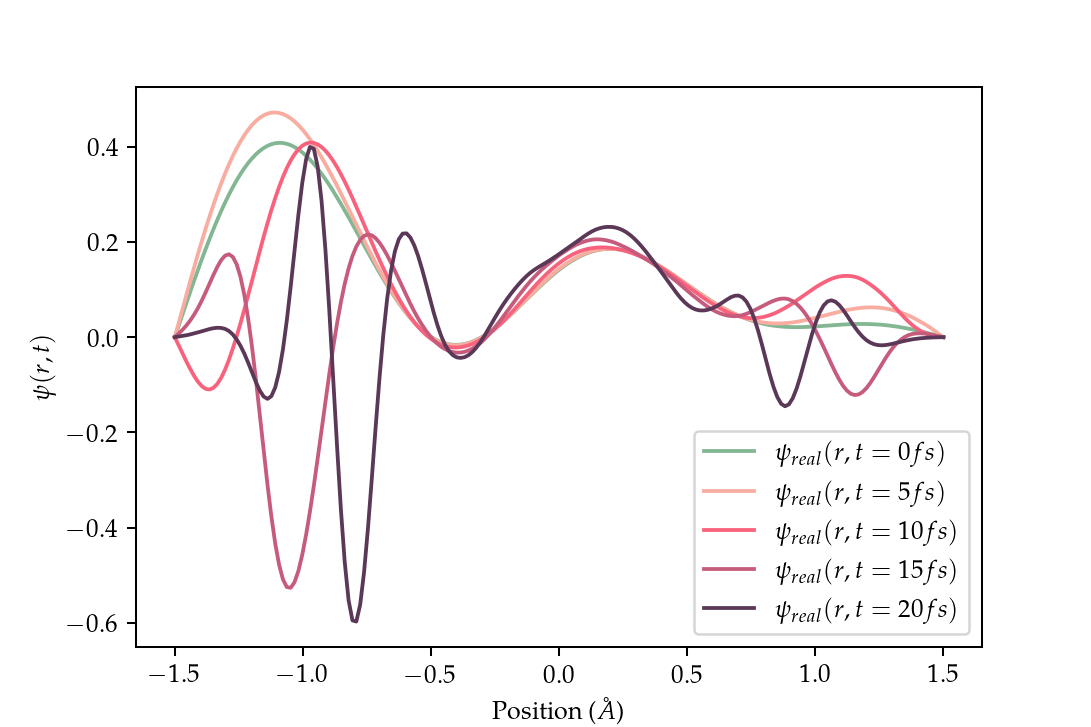

In [157]:
fig, ax = plt.subplots()
#ax.set_title(r"Evolución de wavepacket t parte real")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, ci1.real*0.529, label="$\psi_{real}(r, t=0 fs)$", color=color[0])
ax.plot(r_n*0.5291775, wavet2.real*0.529, label="$\psi_{real}(r, t=5 fs)$", color=color[1])
ax.plot(r_n*0.5291775, wavet3.real*0.529, label="$\psi_{real}(r, t=10 fs)$", color=color[2])
ax.plot(r_n*0.5291775, wavet4.real*0.529, label="$\psi_{real}(r, t=15 fs)$", color=color[3])
ax.plot(r_n*0.5291775, wavet5.real*0.529, label="$\psi_{real}(r, t=20 fs)$", color=color[4])
#ax.plot(r_n*0.5291775, wavet6.real*0.529, label="$\psi_{real}(r, t=5 fs)$")
ax.legend()
#plt.gcf().set_size_inches(6, 4)
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/psi_ev1real.png', dpi=700)

### Evolución temporal de la densidad

<IPython.core.display.Javascript object>


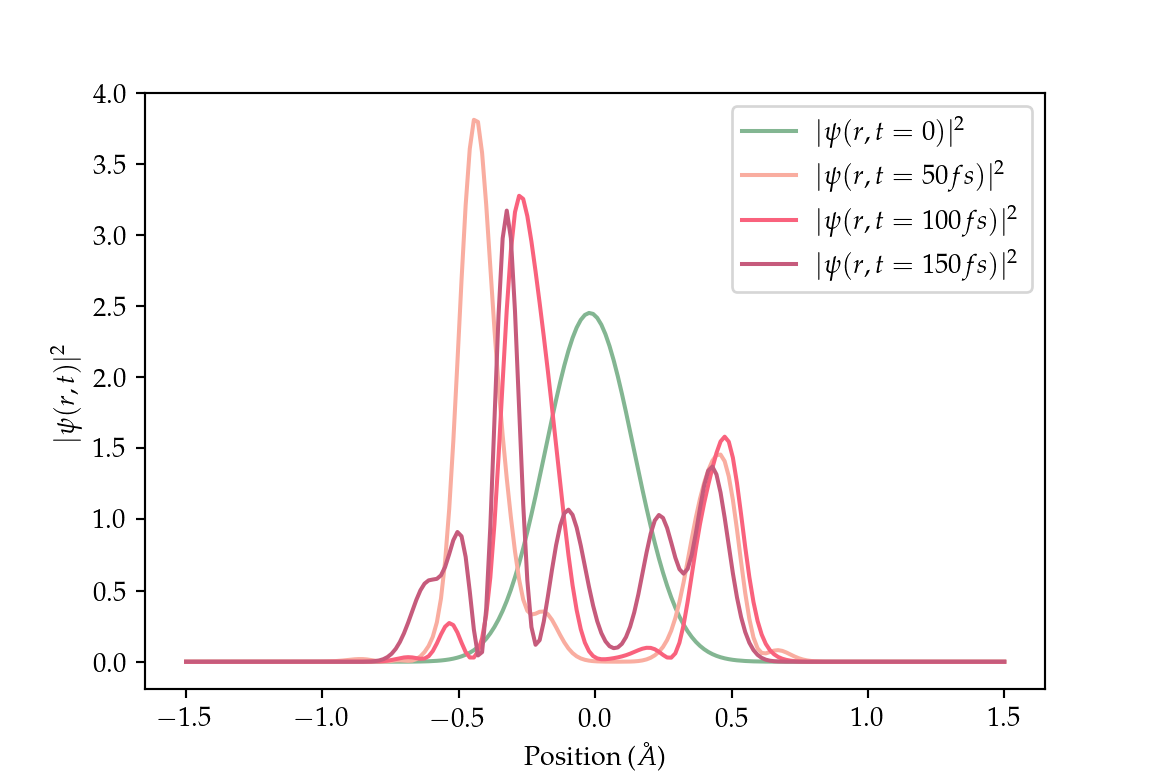

In [217]:
dens1 = (np.abs(onda_gauss1))**2
dens2 = (np.abs(onda_gauss2))**2
dens3 = (np.abs(onda_gauss3))**2
dens4 = (np.abs(onda_gauss4))**2
#dens5 = (np.abs(wavet5))**2
#dens6 = (np.abs(wavet6))**2


fig, ax = plt.subplots()
#ax.set_title(r"Densidad del protón")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$|\psi(r,t)|^{2}$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, dens1*(1/0.5291775), label="$|\psi(r, t=0)|^{2}$", color=color[0])
ax.plot(r_n*0.5291775, dens2*(1/0.5291775), label="$|\psi(r, t=50 fs)|^{2}$", color=color[1])
ax.plot(r_n*0.5291775, dens3*(1/0.5291775), label="$|\psi(r, t=100 fs)|^{2}$", color=color[2])
ax.plot(r_n*0.5291775, dens4*(1/0.5291775), label="$|\psi(r, t=150 fs)|^{2}$", color=color[3])
#ax.plot(r_n*0.5291775, dens5*(1/0.5291775), label="$|\psi(r, t=20 fs)|^{2}$", color=color[4])
#ax.plot(r_n*0.5291775, dens6*(1/0.5291775), label="$|\psi(r, t=5 fs)|^{2}$")
#plt.gcf().set_size_inches(6, 4)
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/dens_ev1', dpi=300)

In [199]:
dens1 = (np.abs(ci1))**2
dens2 = (np.abs(wavet2))**2
dens3 = (np.abs(wavet3))**2
dens4 = (np.abs(wavet4))**2
dens5 = (np.abs(wavet5))**2
#dens6 = (np.abs(wavet6))**2


fig, ax = plt.subplots()
#ax.set_title(r"Densidad del protón")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\theta$')

# Lenght: au -> Angstroms
ax.plot(r_n*0.5291775, dens1*(1/0.5291775), label="$|\psi(r, t=0)|^{2}$", color=color[0])
ax.plot(r_n*0.5291775, dens2*(1/0.5291775), label="$|\psi(r, t=5 fs)|^{2}$", color=color[1])
ax.plot(r_n*0.5291775, dens3*(1/0.5291775), label="$|\psi(r, t=10 fs)|^{2}$", color=color[2])
ax.plot(r_n*0.5291775, dens4*(1/0.5291775), label="$|\psi(r, t=15 fs)|^{2}$", color=color[3])
ax.plot(r_n*0.5291775, dens5*(1/0.5291775), label="$|\psi(r, t=20 fs)|^{2}$", color=color[4])
#ax.plot(r_n*0.5291775, dens6*(1/0.5291775), label="$|\psi(r, t=5 fs)|^{2}$")
#plt.gcf().set_size_inches(6, 4)
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/dens_ev1.png', dpi=700)

NameError: name 'wavet2' is not defined

## Pseudospectral functions

In [167]:
x_0 = -1.5
x_end = 1.5
L = x_end - x_0
n = 200

x_n = np.linspace(x_0,x_end,n+2)

In [168]:
def chi(a,x):
    
    #x_0 = r_n[0]    
    #n = N-1
    #x = x*0.5291775
    C = 1/(np.sqrt(L*(n+1)))
    
    x_arg = (x - x_0)/L
    a_arg = a/(n+1)
    
    arg1 = (n+1)*(np.pi/2)*(x_arg - a_arg)
    arg2 = (n)*(np.pi/2)*(x_arg - a_arg)
    arg3 = (np.pi/2)*(x_arg - a_arg)
    
    arg4 = (n+1)*(np.pi/2)*(x_arg + a_arg)
    arg5 = (n)*(np.pi/2)*(x_arg + a_arg)
    arg6 = (np.pi/2)*(x_arg + a_arg)
    
    A = np.cos(arg1)*(np.sin(arg2)/np.sin(arg3))
    B = np.cos(arg4)*(np.sin(arg5)/np.sin(arg6))
    
    theta = C*(A - B)
    return theta
    

In [169]:
def chi_vec(a, x):
    thetavec = np.empty_like(x)
    for i,j in enumerate(x):
        thetavec[i] = chi(a,j)
    return thetavec

In [183]:
chi1 = chi_vec(1,x_n)
chi2 = chi_vec(10,x_n)
chi3 = chi_vec(22,x_n)
chi4 = chi_vec(32,x_n)
chi5 = chi_vec(42,x_n)

<IPython.core.display.Javascript object>


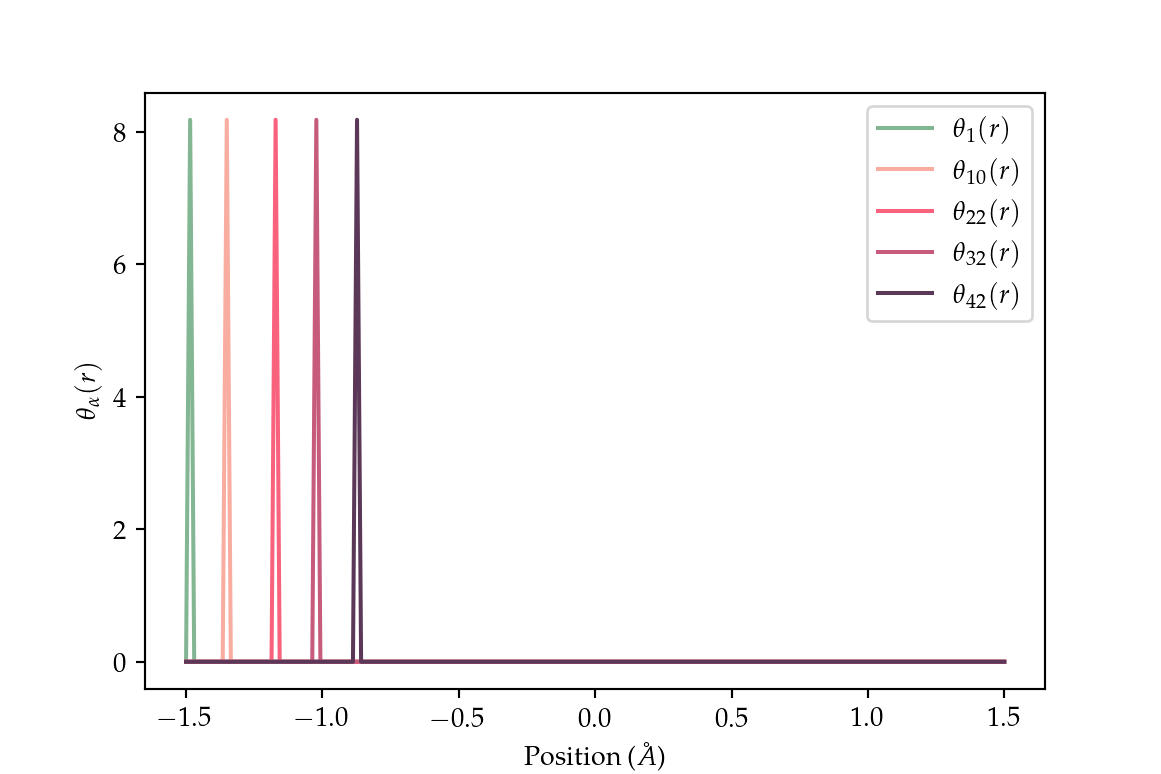

In [214]:
fig, ax = plt.subplots()
#ax.set_title(r"Densidad del protón")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel(r'$\theta_{\alpha}(r)$')


ax.plot(x_n,chi1, label=r"$\theta_{1}(r)$", color=color[0])
ax.plot(x_n,chi2, label=r"$\theta_{10}(r)$", color=color[1])
ax.plot(x_n,chi3, label=r"$\theta_{22}(r)$", color=color[2])
ax.plot(x_n,chi4, label=r"$\theta_{32}(r)$", color=color[3])
ax.plot(x_n,chi5, label=r"$\theta_{42}(r)$", color=color[4])
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/theta_n1.png', dpi=300)

$\theta$